# Charts showing progression of infections and deaths by country

 ## 0.Import python packages

In [1]:
# for data managaement
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta

# for charting
import plotly
import plotly.graph_objects as go


## 1. Import and Inspect data

In [2]:
data = pd.read_csv('https://opendata.ecdc.europa.eu/covid19/casedistribution/csv',usecols = list(range(0,10)))

## 2. Data cleaning & wrangling

In [8]:
# make datetime
data['dateRep'] = pd.to_datetime(data['dateRep'], dayfirst=True)

#sort values by country and date
data.sort_values(by=['countriesAndTerritories','dateRep'], ascending = True, inplace = True)

#reindex the data now its sorted to prevent errors when creating aggregates
data = data.reindex()

Check data are now ordered correctly

## 3. What we're trying to make (example from FT.com)
* A chart showing the trajectory of cases/deaths by country indexed from a point near the beginning of the Covid-19 outbreak 
* A chart where we can select which countries we want to view
* A chart that we can update with new data

In [9]:
from IPython.display import Image

Deaths | Cases
- | - 
![alt](Assets/FT_chart1.jpg) | ![alt](Assets/FT_chart2.jpg)

### First we need to create some new variables to allow us to plot the data

* Create cmumulative sum of deaths and cases by country

In [10]:
data['total_cases'] = data.groupby(by='countriesAndTerritories')['cases'].cumsum()
data['total_deaths'] = data.groupby(by='countriesAndTerritories')['deaths'].cumsum()

# 4. Building the charts

* Define some useful functions

In [11]:
# generates datasets 
def make_chart_data(country):
    ''' makes a seperate dataset for a country
        takes country name as input '''
    chart_data = data.loc[data['countriesAndTerritories'] == country].reset_index()
    return chart_data

# shifts the data to 'day 0 of the corona virus'
def reindex(df, var, index_ = 10):
    ''' creates a data series which shifts data so that the day 
    where the criteria index_ is reached is at index 0
    Note cases are indexed to weekly total, while deaths to cumulative total'''
    dta = df.copy()
    
    # First we need to identify the day at which the minimum number of cases/deaths is reached
    # some countries have no data so the try/except allows the function to ignore them
    try: 
        if var == 'total_cases':
            first_day = dta[dta['total_cases']>index_ ].index[0]
        elif var == 'total_deaths':
            first_day = dta[dta['total_deaths']>index_].index[0]
        else:
            pass
    # The cumulative cases/deaths data are then shifted back so that the first day index_ is exceeded becomes index 0
        dta[var] = dta[var].shift(-first_day)
    except:
        dta[var] = np.nan
    return dta 


* Create the basic chart

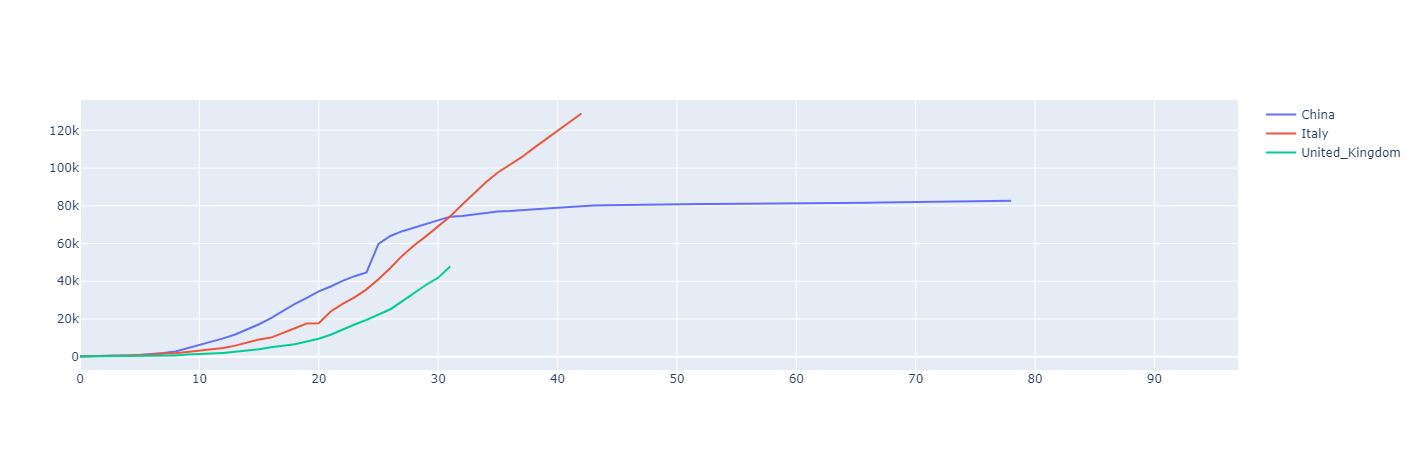

In [13]:
# choose the countries we want on the plot
countries = ['China','Italy','United_Kingdom']

# choose whether we want to plot total_cases or total_deaths
var = 'total_cases'

# choose how many cumulative deaths/or cases to use as point 0
index_ = 100

# create dataframes for plotting and traces in a loop ... useful when there's lots of them

dfs = dict()
traces = dict()
plots = []
for i in countries:
    try:
        dfs[i] = reindex(make_chart_data(i),var,index_)
        traces[i] = go.Scatter(x=dfs[i].index, y=dfs[i][var], mode = 'lines', name = i)
        plots.append(traces[i])
            
    except:
        pass
    
fig = go.Figure(plots)
fig.show()

* Allow us to select any country and add some axis labels

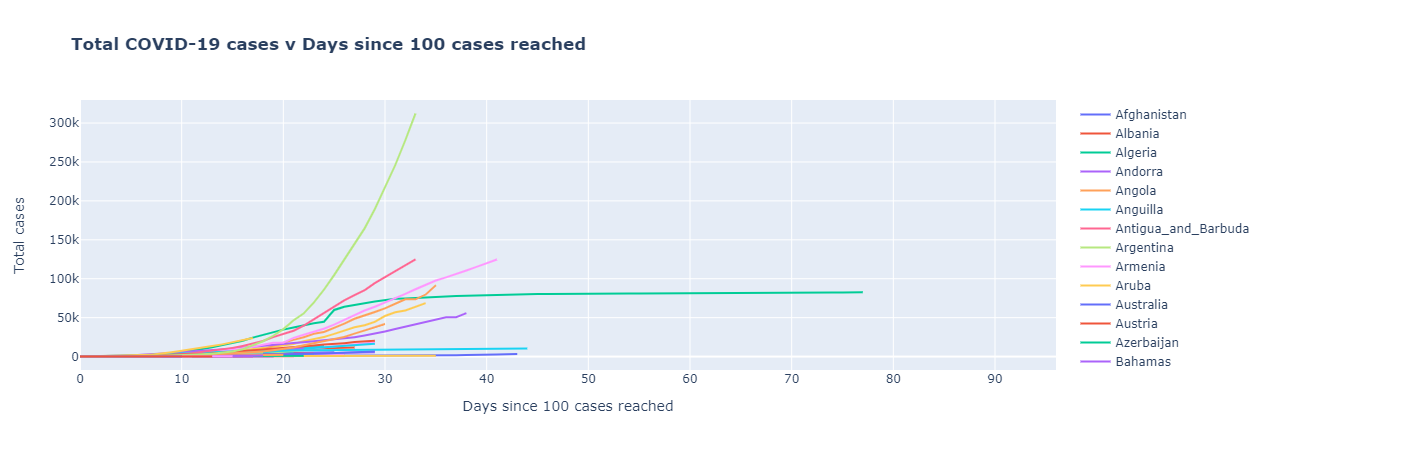

In [38]:
# choose the countries we want on the plot
countries = data['countriesAndTerritories'].unique()

# choose whether we want to plot total_cases or total_deaths
var = 'total_cases'

# choose how many cumulative deaths/or cases to use as point 0
index_ = 100

# create dataframes for plotting and traces in a loop ... useful when there's lots of them

dfs = dict()
traces = dict()
plots = []

for i in countries:
    try:
        dfs[i] = reindex(make_chart_data(i),var,index_)
        traces[i] = go.Scatter(x=dfs[i].index, y=dfs[i][var], mode = 'lines', name = i)
        plots.append(traces[i])
            
    except:
        pass
    
fig = go.Figure(plots)
#
fig.update_layout( title="<b>Total COVID-19 cases v Days since "+str(index_)+" "+ var.split('_')[1]+" reached")
fig.layout.xaxis.update(title='Days since '+ str(index_)+' '+ var.split('_')[1] +' reached')
fig.layout.yaxis.update(title=(' '.join(var.split('_')).capitalize()))


fig.show()

* Make the Y scale logarithmic and show only a few countries on the chart to begin with

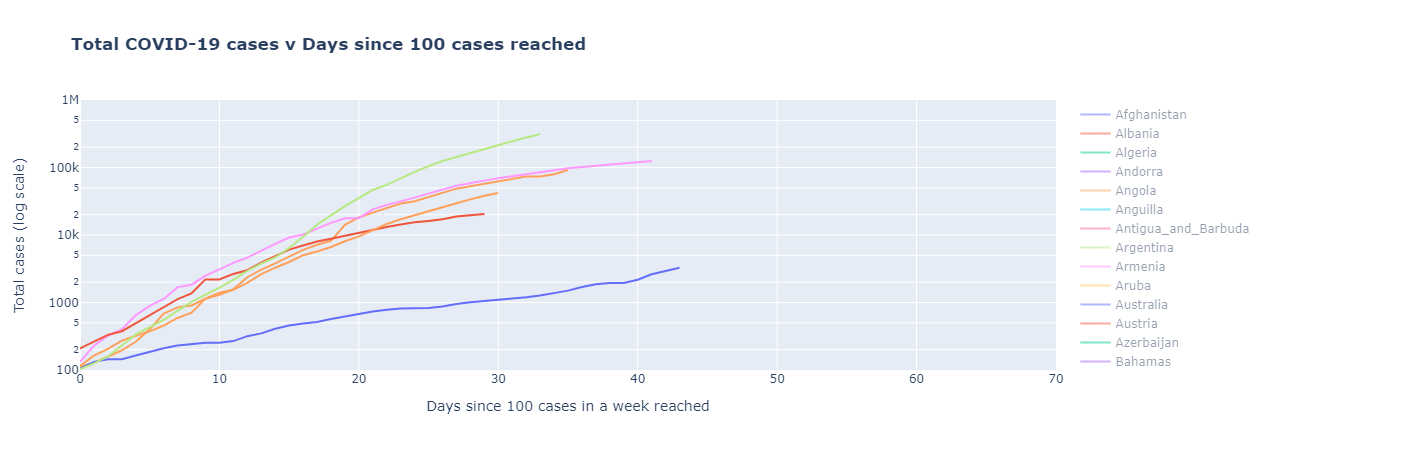

In [40]:
# choose the countries we want on the plot
countries = data['countriesAndTerritories'].unique()

# choose whether we want to plot total_cases or total_deaths
var = 'total_cases'

# choose how many cumulative deaths/or cases to use as point 0
index_ = 100

# list the countries you want to be on there as a default
default_list = ['Germany','Japan','United_Kingdom','Italy','Switzerland']

dfs = dict()
traces = dict()
plots = []

for i in countries:
    try:
        # a condition is added into the loop so that countries not in default_list see the argument visible set to 'legendonly'
        if i in default_list:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index, 
                                   y=dfs[i][var], 
                                   mode = 'lines', 
                                   name = i)
            plots.append(traces[i])
        else:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var], 
                                   mode = 'lines',
                                   name = i, 
                                   visible = 'legendonly')
            plots.append(traces[i])
            
    except:
        pass


fig = go.Figure(plots)

# set yaxis_type to "log"
fig.update_layout(yaxis_type="log", title="<b>Total COVID-19 cases v Days since "+str(index_)+" "+ var.split('_')[1]+" reached")

fig.layout.xaxis.update(title='Days since '+ str(index_)+' '+ var.split('_')[1] +' in a week reached', range=[0, 70])
fig.layout.yaxis.update(title=(' '.join(var.split('_')).capitalize()+' (log scale)'), range=[np.log10(index_), 6])
fig.show()
    

* Add lines to show rate of increase 

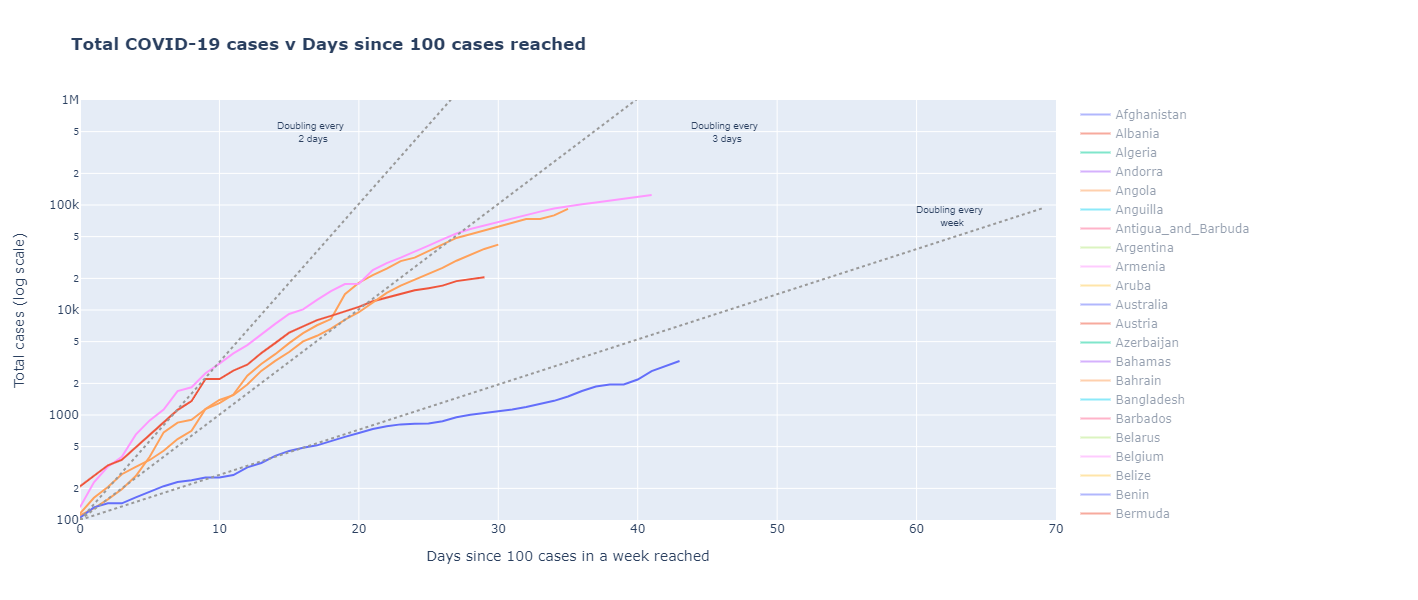

In [45]:
# choose the countries we want on the plot
countries = data['countriesAndTerritories'].unique()

# choose whether we want to plot total_cases or total_deaths
var = 'total_cases'

# choose how many cumulative deaths/or cases to use as point 0
index_ = 100

# list the countries you want to be on there as a default
default_list = ['Germany','Japan','United_Kingdom','Italy','Switzerland']

dfs = dict()
traces = dict()
plots = []

# add list for collecting annotations

annotations = []

for i in countries:
    try:
        # a condition is added into the loop so that countries not in default_list see the argument visible set to 'legendonly'
        if i in default_list:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index, 
                                   y=dfs[i][var], 
                                   mode = 'lines', 
                                   name = i)
            plots.append(traces[i])
        else:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var], 
                                   mode = 'lines',
                                   name = i, 
                                   visible = 'legendonly')
            plots.append(traces[i])
            
    except:
        pass


# create traces for the lines you want to plot (as for the other lines)
    
three_days = go.Scatter(x=np.array(range(0,70)),
                        y=index_*(2**(1/3))**np.array(range(0,70)), 
                        mode = 'lines', 
                        line = dict(color='#999999', shape ='hv', dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every three days',
                        hoverinfo='skip')

two_days = go.Scatter(x=np.array(range(0,70)),
                      y=index_*(2**(1/2))**np.array(range(0,70)),
                      mode = 'lines',
                      line = dict(color='#999999', shape ='hv', dash='dot'),
                      line_shape = 'linear', 
                      name = 'Doubling every two days',
                      hoverinfo='skip')

seven_days = go.Scatter(x=np.array(range(0,70)),
                        y=index_*(2**(1/7))**np.array(range(0,70)),
                        mode = 'lines',
                        line = dict(color='#999999',shape ='hv',dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every week',
                        hoverinfo='skip')

# add the lines to the list of traces to plot
plots.append(three_days)
plots.append(two_days)
plots.append(seven_days)

# add annotations to the lines so people can see what they are

annotations.append(dict(xref='paper', 
                        x=0.2, 
                        y=5.7,
                        text='Doubling every <BR> 2 days',
                        font=dict(family='Arial',size=10),
                        showarrow=False))
annotations.append(dict(xref='paper',
                        x=0.7, 
                        y=5.7,
                        text='Doubling every <BR> 3 days',
                        font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper',
                        x=0.93,
                        y=4.9,
                        text='Doubling every <BR> week',
                        font=dict(family='Arial',size=10),showarrow=False))
    
    
fig = go.Figure(plots)
fig.update_layout(yaxis_type="log",
                  height = 600, 
                  width = 900,
                  title="<b>Total COVID-19 cases v Days since "+str(index_)+" "+ var.split('_')[1]+" reached",
                  annotations = annotations)

fig.layout.xaxis.update(title='Days since '+ str(index_)+' '+ var.split('_')[1] +' in a week reached',
                        range=[0, 70])
fig.layout.yaxis.update(title=(' '.join(var.split('_')).capitalize()+' (log scale)'),
                        range=[np.log10(index_), 6])
fig.show()

## Some final bits of tidying up
* Formatting the Hoverlabels
* Adding a subtitle and footnote
* Getting rid of underscores in country names

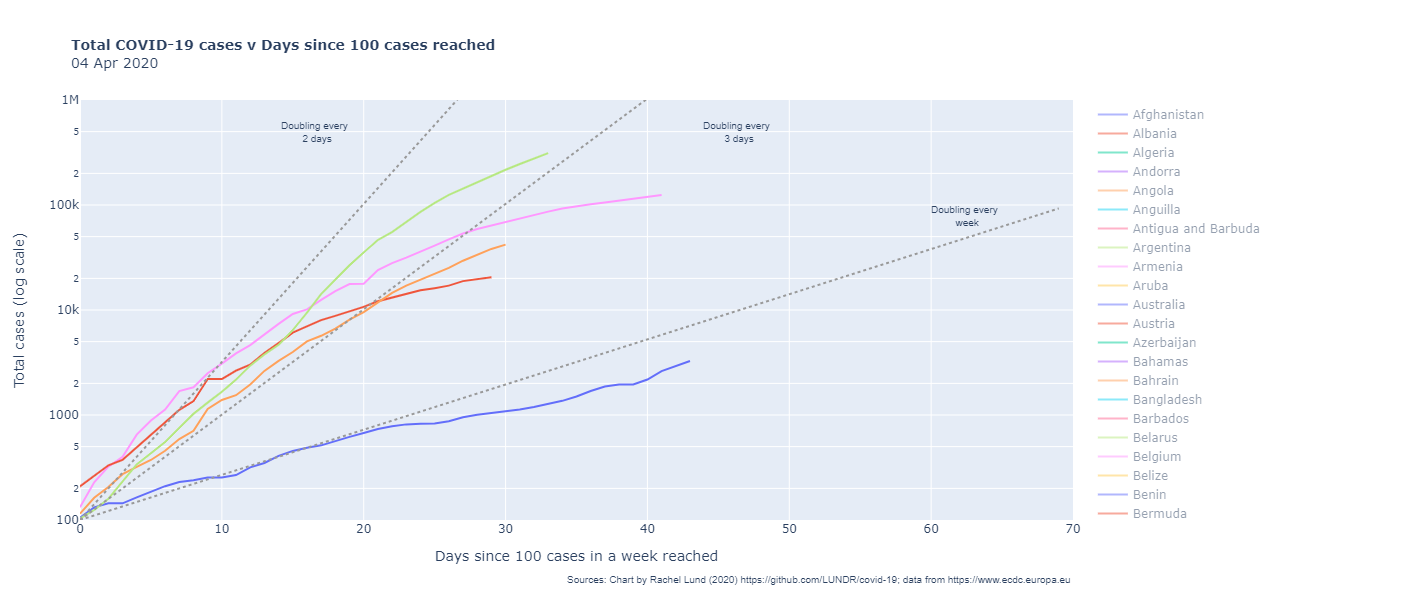

In [52]:
# choose the countries we want on the plot
countries = data['countriesAndTerritories'].unique()

# choose whether we want to plot total_cases or total_deaths
var = 'total_cases'

# choose how many cumulative deaths/or cases to use as point 0
index_ = 100

# list the countries you want to be on there as a default
default_list = ['United_States_of_America','Japan','United_Kingdom','Italy','Switzerland']

# calculate the date of latest data included: NB there is a lag of a day so we need to subtract a day from the latest data reported.
latest_data = data['dateRep'].max()- timedelta(days=1)
latest_data_string = latest_data.strftime("%d %b %Y")

dfs = dict()
traces = dict()
plots = []
annotations = []


for i in countries:
    try:
        if i in default_list:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var],
                                   mode = 'lines', 
                                   line = dict(shape ='hv'),
                                   marker = dict(), 
                                   line_shape = 'linear',
                                   name = ' '.join(i.split('_')), # Removes the underscores in the legend names for countries
                                   text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']], # Removes the underscores in the hoverlabel names
                                   hovertemplate = "<br><b>%{text}</b><br><i>Cases</i>: %{y:,}<extra></extra>") # formats the hoverlabels
            plots.append(traces[i])
        else:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var],
                                   mode = 'lines',
                                   line = dict(shape ='hv'),marker = dict(),
                                   line_shape = 'linear',
                                   name = ' '.join(i.split('_')), 
                                   visible = 'legendonly',
                                   text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']],
                                   hovertemplate = "<br><b>%{text}</b><br><i>Cases</i>: %{y:,}<extra></extra>")
            plots.append(traces[i])
            
    except:
        pass
    


# create traces for the lines you want to plot (as for the other lines)
    
three_days = go.Scatter(x=np.array(range(0,70)),
                        y=index_*(2**(1/3))**np.array(range(0,70)), 
                        mode = 'lines', 
                        line = dict(color='#999999', shape ='hv', dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every three days',
                        hoverinfo='skip')

two_days = go.Scatter(x=np.array(range(0,70)),
                      y=index_*(2**(1/2))**np.array(range(0,70)),
                      mode = 'lines',
                      line = dict(color='#999999', shape ='hv', dash='dot'),
                      line_shape = 'linear', 
                      name = 'Doubling every two days',
                      hoverinfo='skip')

seven_days = go.Scatter(x=np.array(range(0,70)),
                        y=index_*(2**(1/7))**np.array(range(0,70)),
                        mode = 'lines',
                        line = dict(color='#999999',shape ='hv',dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every week',
                        hoverinfo='skip')

# add the lines to the list of traces to plot
plots.append(three_days)
plots.append(two_days)
plots.append(seven_days)

# add annotations to the lines so people can see what they are

annotations.append(dict(xref='paper', 
                        x=0.2, 
                        y=5.7,
                        text='Doubling every <BR> 2 days',
                        font=dict(family='Arial',size=10),
                        showarrow=False))
annotations.append(dict(xref='paper',
                        x=0.7, 
                        y=5.7,
                        text='Doubling every <BR> 3 days',
                        font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper',
                        x=0.93,
                        y=4.9,
                        text='Doubling every <BR> week',
                        font=dict(family='Arial',size=10),showarrow=False))
    

# add a footnote

footnote = dict(xref='paper', xanchor='right', x=1, yanchor='top',y=np.log10(index_),text='<BR> <BR> <BR> <BR> <BR>Sources: Chart by Rachel Lund (2020) https://github.com/LUNDR/covid-19; data from https://www.ecdc.europa.eu',font=dict(family='Arial',size=10),showarrow=False)
annotations.append(footnote)
  
    
fig = go.Figure(plots)
fig.update_layout(yaxis_type="log",
                  height = 600, 
                  width = 900,
                  title="<b>Total COVID-19 cases v Days since "+str(index_)+" "+ var.split('_')[1]+" reached</b> <BR>"+latest_data_string,
                  annotations = annotations,
                 titlefont ={
                            "size": 14
                  })

fig.layout.xaxis.update(title='Days since '+ str(index_)+' '+ var.split('_')[1] +' in a week reached',
                        range=[0, 70])
fig.layout.yaxis.update(title=(' '.join(var.split('_')).capitalize()+' (log scale)'),
                        range=[np.log10(index_), 6])
fig.show()

# Now we can use the same code to plot deaths
* we just need to change the var,
* the scale of the axes, and;
* probably the index_

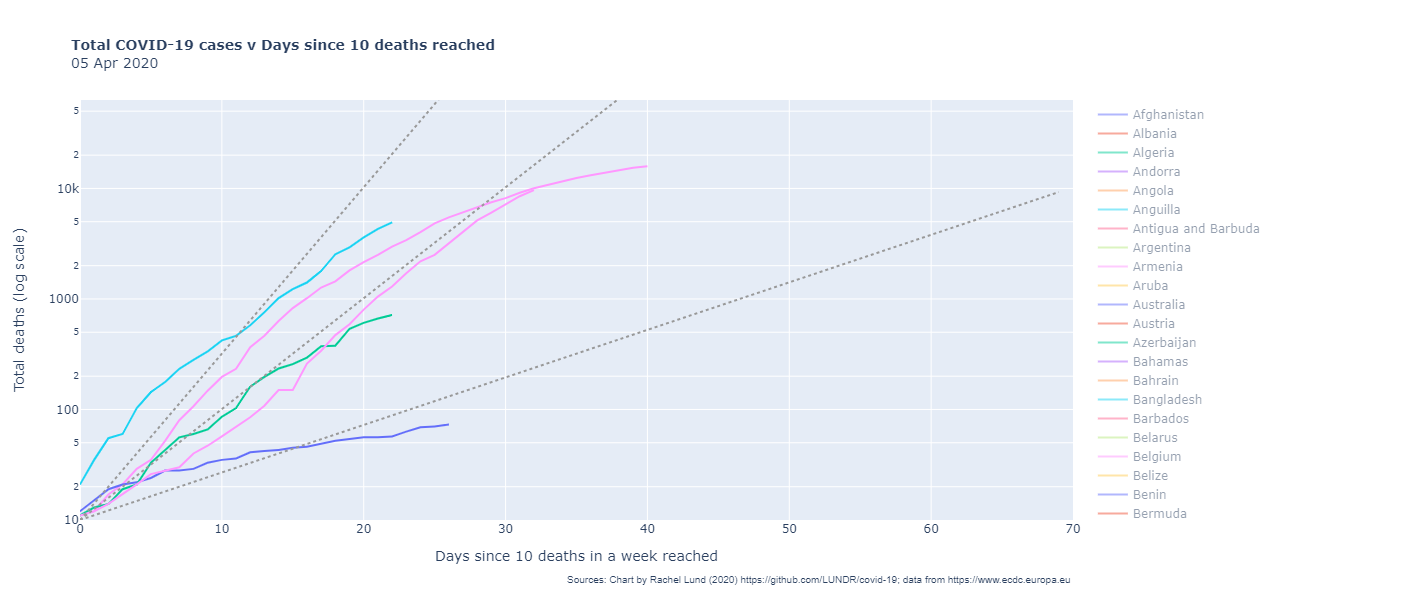

In [15]:
# choose the countries we want on the plot
countries = data['countriesAndTerritories'].unique()

# choose whether we want to plot total_cases or total_deaths
var = 'total_deaths'

# choose how many cumulative deaths/or cases to use as point 0
index_ = 10

# list the countries you want to be on there as a default
default_list = ['United_States_of_America','Japan','United_Kingdom','Italy','Switzerland']

# calculate the date of latest data included: NB there is a lag of a day so we need to subtract a day from the latest data reported.
latest_data = data['dateRep'].max()- timedelta(days=1)
latest_data_string = latest_data.strftime("%d %b %Y")

dfs = dict()
traces = dict()
plots = []
annotations = []


for i in countries:
    try:
        if i in default_list:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var],
                                   mode = 'lines', 
                                   line = dict(shape ='hv'),
                                   marker = dict(), 
                                   line_shape = 'linear',
                                   name = ' '.join(i.split('_')), # Removes the underscores in the legend names for countries
                                   text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']], # Removes the underscores in the hoverlabel names
                                   hovertemplate = "<br><b>%{text}</b><br><i>Deaths</i>: %{y:,}<extra></extra>") # formats the hoverlabels
            plots.append(traces[i])
        else:
            dfs[i] = reindex(make_chart_data(i),var,index_)
            traces[i] = go.Scatter(x=dfs[i].index,
                                   y=dfs[i][var],
                                   mode = 'lines',
                                   line = dict(shape ='hv'),marker = dict(),
                                   line_shape = 'linear',
                                   name = ' '.join(i.split('_')), 
                                   visible = 'legendonly',
                                   text = [' '.join(x.split('_')) for x in dfs[i]['countriesAndTerritories']],
                                   hovertemplate = "<br><b>%{text}</b><br><i>Deaths</i>: %{y:,}<extra></extra>")
            plots.append(traces[i])
            
    except:
        pass
    


# create traces for the lines you want to plot (as for the other lines)
    
three_days = go.Scatter(x=np.array(range(0,70)),
                        y=index_*(2**(1/3))**np.array(range(0,70)), 
                        mode = 'lines', 
                        line = dict(color='#999999', shape ='hv', dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every three days',
                        hoverinfo='skip')

two_days = go.Scatter(x=np.array(range(0,70)),
                      y=index_*(2**(1/2))**np.array(range(0,70)),
                      mode = 'lines',
                      line = dict(color='#999999', shape ='hv', dash='dot'),
                      line_shape = 'linear', 
                      name = 'Doubling every two days',
                      hoverinfo='skip')

seven_days = go.Scatter(x=np.array(range(0,70)),
                        y=index_*(2**(1/7))**np.array(range(0,70)),
                        mode = 'lines',
                        line = dict(color='#999999',shape ='hv',dash='dot'),
                        line_shape = 'linear', 
                        name = 'Doubling every week',
                        hoverinfo='skip')

# add the lines to the list of traces to plot
plots.append(three_days)
plots.append(two_days)
plots.append(seven_days)

# add annotations to the lines so people can see what they are

annotations.append(dict(xref='paper', 
                        x=0.2, 
                        y=5.7,
                        text='Doubling every <BR> 2 days',
                        font=dict(family='Arial',size=10),
                        showarrow=False))
annotations.append(dict(xref='paper',
                        x=0.7, 
                        y=5.7,
                        text='Doubling every <BR> 3 days',
                        font=dict(family='Arial',size=10),showarrow=False))
annotations.append(dict(xref='paper',
                        x=0.93,
                        y=4.9,
                        text='Doubling every <BR> week',
                        font=dict(family='Arial',size=10),showarrow=False))
    

# add a footnote

footnote = dict(xref='paper', xanchor='right', x=1, yanchor='top',y=np.log10(index_),text='<BR> <BR> <BR> <BR> <BR>Sources: Chart by Rachel Lund (2020) https://github.com/LUNDR/covid-19; data from https://www.ecdc.europa.eu',font=dict(family='Arial',size=10),showarrow=False)
annotations.append(footnote)
  
    
fig = go.Figure(plots)
fig.update_layout(yaxis_type="log",
                  height = 600, 
                  width = 900,
                  title="<b>Total COVID-19 cases v Days since "+str(index_)+" "+ var.split('_')[1]+" reached</b> <BR>"+latest_data_string,
                  annotations = annotations,
                 titlefont ={
                            "size": 14
                  })

fig.layout.xaxis.update(title='Days since '+ str(index_)+' '+ var.split('_')[1] +' in a week reached',
                        range=[0, 70])
fig.layout.yaxis.update(title=(' '.join(var.split('_')).capitalize()+' (log scale)'),
                        range=[np.log10(index_), 4.8])
fig.show()
    